In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

import warnings
warnings.filterwarnings('ignore')


In [ ]:
# Load Wine dataset from sklearn
wine = load_wine()
X = pd.DataFrame(wine.data, columns=wine.feature_names)
y = wine.target  # Not used for clustering, just for reference

X.head()


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0


In [ ]:
# Prepare multiple preprocessing methods
preprocessed_data = {
    'StandardScaler': StandardScaler().fit_transform(X),
    'MinMaxScaler': MinMaxScaler().fit_transform(X),
    'RobustScaler': RobustScaler().fit_transform(X),
    'PCA (2D after StandardScaler)': PCA(n_components=2).fit_transform(StandardScaler().fit_transform(X))
}


In [ ]:
def evaluate_clustering(X, labels):
    sil = silhouette_score(X, labels)
    ch = calinski_harabasz_score(X, labels)
    db = davies_bouldin_score(X, labels)
    return sil, ch, db


In [ ]:
results = []

algorithms = {
    'KMeans-3': KMeans(n_clusters=3, random_state=42),
    'KMeans-4': KMeans(n_clusters=4, random_state=42),
    'Agglomerative-3': AgglomerativeClustering(n_clusters=3),
    'Agglomerative-4': AgglomerativeClustering(n_clusters=4),
    'DBSCAN': DBSCAN(eps=1.2, min_samples=5)  # Adjusted eps for wine dataset
}

for method, data in preprocessed_data.items():
    for algo_name, algo in algorithms.items():
        try:
            labels = algo.fit_predict(data)
            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
            if n_clusters > 1:
                sil, ch, db = evaluate_clustering(data, labels)
                results.append({
                    'Preprocessing': method,
                    'Algorithm': algo_name,
                    'Clusters': n_clusters,
                    'Silhouette Score': sil,
                    'Calinski-Harabasz': ch,
                    'Davies-Bouldin': db
                })
        except Exception as e:
            print(f"Error with {method} - {algo_name}: {e}")


In [ ]:
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='Silhouette Score', ascending=False)
results_df.reset_index(drop=True, inplace=True)

results_df


,Preprocessing,Algorithm,Clusters,Silhouette Score,Calinski-Harabasz,Davies-Bouldin
0,PCA (2D after StandardScaler),KMeans-3,3,0.560170,343.949210,0.597723
1,PCA (2D after StandardScaler),Agglomerative-3,3,0.559088,341.058245,0.601336
2,PCA (2D after StandardScaler),KMeans-4,4,0.491421,328.515500,0.742231
3,PCA (2D after StandardScaler),Agglomerative-4,4,0.481286,307.241141,0.718657
4,MinMaxScaler,KMeans-3,3,0.300894,83.351128,1.308640
5,MinMaxScaler,Agglomerative-3,3,0.294829,81.327639,1.318311
6,StandardScaler,KMeans-3,3,0.284859,70.940008,1.389188
7,StandardScaler,Agglomerative-3,3,0.277444,67.647468,1.418592
8,RobustScaler,KMeans-3,3,0.264467,60.991331,1.468775
9,RobustScaler,Agglomerative-3,3,0.256293,58.669520,1.467144


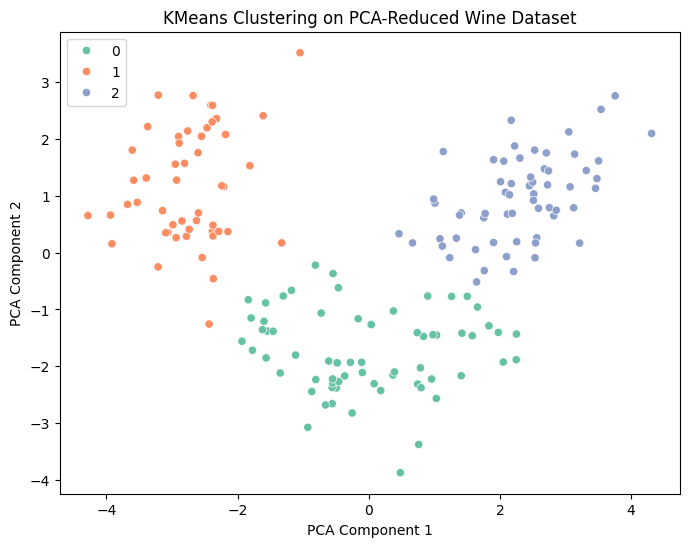

In [ ]:
# Visualize best clustering (3 clusters, PCA)
pca_data = preprocessed_data['PCA (2D after StandardScaler)']
kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(pca_data)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_data[:, 0], y=pca_data[:, 1], hue=labels, palette='Set2')
plt.title('KMeans Clustering on PCA-Reduced Wine Dataset')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()


In [ ]:
best = results_df.iloc[0]
print("Best Performing Setup:")
print(f"- Preprocessing: {best['Preprocessing']}")
print(f"- Algorithm: {best['Algorithm']}")
print(f"- Clusters: {best['Clusters']}")
print(f"- Silhouette Score: {best['Silhouette Score']:.3f}")
print(f"- Calinski-Harabasz Index: {best['Calinski-Harabasz']:.2f}")
print(f"- Davies-Bouldin Index: {best['Davies-Bouldin']:.3f}")


Best Performing Setup:
- Preprocessing: PCA (2D after StandardScaler)
- Algorithm: KMeans-3
- Clusters: 3
- Silhouette Score: 0.560
- Calinski-Harabasz Index: 343.95
- Davies-Bouldin Index: 0.598
